In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config; set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics.pairwise import sigmoid_kernel

In [141]:
dfbrew = pd.read_csv("../raw_data/Beers_Breweries_and_Beer Reviews/breweries.csv")
dfbeer = pd.read_csv("../raw_data/beers_style_renamed.csv")
dftop = pd.read_csv("../raw_data/top_beer_info_style_renamed.csv")

In [142]:
#read correspondance brewery
corres_xls = pd.read_excel('../assets/correspondance_breweryclean2.xlsx')
corres_xls.drop(columns='Unnamed: 0', inplace=True)
corres_xls.set_index(1, inplace=True)
corres= corres_xls.to_dict()
#corres[0]

/Users/alix/.pyenv/versions/3.8.6/envs/zytholic_project/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [143]:
dfbrew = dfbrew.rename(columns={"name": "brewery"})
dfbrew = dfbrew.rename(columns={"id": "brewery_id"})

dfbrew['brewery'].replace(corres[0], inplace=True)

dfbrewb =  pd.merge(dfbeer,dfbrew[['brewery_id','brewery']],how='left',on=['brewery_id'])

dftopbrew = pd.merge(dftop,dfbrewb[['name', 'brewery', 'state', 'country', 'retired']],
                     how='inner',on=['name','brewery'])

In [226]:
working_df = dftopbrew.drop(['description', 'key', 'style key'], axis= 1).drop_duplicates()
print(working_df.shape)
working_df = working_df[working_df.retired == 'f']
working_df.shape
#working_df['style'] = [st.split(' - ')[0] for st in working_df['style']]

(4377, 21)


(4325, 21)

In [68]:
tastes_features = working_df.select_dtypes(np.number).columns[2:]
tastes_features

Index(['min ibu', 'max ibu', 'astringency', 'body', 'alcohol', 'bitter',
       'sweet', 'sour', 'salty', 'fruits', 'hoppy', 'spices', 'malty'],
      dtype='object')

In [69]:
X_train, X_test = train_test_split(working_df, test_size=0.25)

In [132]:
pipe_style_country = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe_abv_rating = make_pipeline(StandardScaler())
pipe_taste_features = make_pipeline(MinMaxScaler())
pipe_state = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=''),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

preprocess = make_column_transformer(
    (pipe_style_country, ['style', 
                          #'country'
                         ]),
    #(pipe_state, ['state']),
    (pipe_abv_rating, ['abv', 'ave rating']),
    (pipe_taste_features, tastes_features)
    
)

In [133]:
preprocess

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['style']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['abv', 'ave rating']),
                                ('pipeline-3',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['min ibu', 'max ibu', 'astringency', 'body', 'alcohol', 'bitter',
       'sweet', 'sour', 'salty', 'fruits', 'hoppy', 'spices', 'malty'],
      dtype='object'))])

In [72]:
preprocess.fit(X_train)
X_train_proc = preprocess.transform(X_train)
X_test_proc = preprocess.transform(X_test)

In [74]:
X_train_proc.shape, X_test_proc.shape

((3243, 104), (1082, 104))

In [96]:

inertias2 = []
for k in range(30, 100):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias.append(res.inertia_)

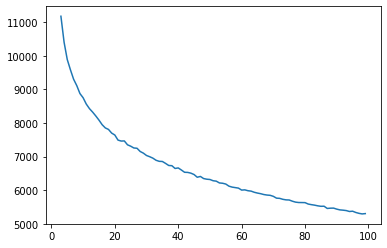

In [97]:
plt.plot(range(3, 100),inertias)

In [112]:
inertias2 = []
for k in range(10, 30):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias2.append(res.inertia_)

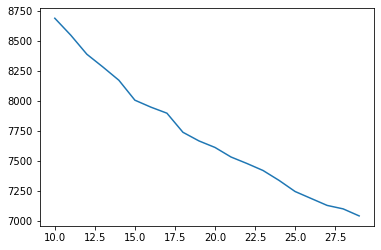

In [113]:
plt.plot(range(10, 30),inertias2)

In [114]:
cluster = KMeans(n_clusters=20)
cluster.fit(X)

KMeans(n_clusters=20)

In [115]:
X_test['group'] = cluster.predict(y)

/var/folders/_5/s9wbxcy503dggw34b98btk9c0000gp/T/ipykernel_12698/319366407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['group'] = cluster.predict(y)


In [121]:
X_test.group.value_counts()

3     152
6     106
15    104
12     83
0      68
11     64
4      54
7      54
1      48
18     45
2      44
8      43
14     41
10     40
13     37
9      33
16     20
5      19
17     16
19     11
Name: group, dtype: int64

In [125]:
X_test[X_test.group == 16]

,name,style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,sour,salty,fruits,hoppy,spices,malty,state,country,retired,group
1290,NetherWorld Cascadian Dark Ale,IPA,Flying Monkeys Craft Brewery,6.0,3.85,50,70,30,72,8,...,41,0,53,115,13,111,ON,CA,f,16
753,Slingshot,Steam Beer,Radical Road Brewing Co.,5.0,3.67,35,45,6,11,1,...,0,0,0,22,1,17,ON,CA,f,16
1071,Buenos Dias,Ale Gruit / Ancient Herbed,Beau's All Natural Brewing Company,4.5,3.71,0,0,15,13,1,...,63,26,72,25,4,23,ON,CA,f,16
737,33 Acres Of Life,Steam Beer,33 Acres Brewing Co.,4.8,3.78,35,45,5,4,4,...,4,0,4,10,5,11,BC,CA,f,16
841,Cosmic Cream Ale,Ale Cream,Cameron's Brewing Co.,5.0,3.27,10,22,11,63,10,...,29,2,27,37,14,74,ON,CA,f,16
3620,Martello Stout,Stout,Garrison Brewing Company,4.8,3.89,20,40,10,83,6,...,4,0,3,30,12,139,NS,CA,f,16
2778,Stranger Than Fiction,Porter,Collective Arts Brewing,5.5,4.01,20,30,19,113,10,...,16,0,18,49,21,137,ON,CA,f,16
1347,Dead Elephant,IPA,Railway City Brewing Company,6.5,3.58,35,60,22,34,12,...,57,0,75,90,8,63,ON,CA,f,16
1086,La Clef Des Champs,Ale Gruit / Ancient Herbed,Brasserie Dieu du Ciel!,5.0,3.54,0,0,1,4,1,...,1,0,1,17,1,11,QC,CA,f,16
33,Festivale,Altbier,Beau's All Natural Brewing Company,4.7,3.69,25,50,29,30,9,...,20,0,20,104,10,141,ON,CA,f,16


In [24]:
%load_ext autoreload
%reload_ext autoreload
from zytholic_project.base_model import BaseModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
model = BaseModel()

model.get_data()

model.set_preprocess_pipeline()

model.process_data()


/Users/alix/.pyenv/versions/3.8.6/envs/zytholic_project/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [116]:
model.X_train_proc.shape

(3243, 104)

In [168]:
# compute sigmoid distance
sigmoid = sigmoid_kernel(
    model.X_train_proc,
    model.X_train_proc
)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [169]:
# Dataframe to get index of beers
df = model.X_train.copy()
df.reset_index(drop=True, inplace=True)
df.reset_index(inplace=True)
index = df.iloc[:,:4]
#index

In [170]:
# Get the 10 closest beers
def content(name,sigmoid=sigmoid):
        position = df[df.name == name]['index']
        score = sorted(
            list(enumerate(sigmoid[position][0])),
            key=lambda x:x[1],reverse=True)
        indices = score[1:11]
        beers_indices = [i[0] for i in indices]
        # Top 10 most similar beers
        return df.iloc[beers_indices]

In [184]:
content('Mexican Chocolate Stout')

,index,name,style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty,state,country,retired
1650,1650,Coffee Cinnamon B-Bomb,Ale Strong,Fremont Brewing Company,13.0,4.57,40,100,4,105,77,77,69,8,0,31,10,91,176,WA,US,f
62,62,Black Tuesday,Stout Imperial,The Bruery,19.5,4.59,50,80,3,70,95,25,106,17,1,43,3,30,126,CA,US,f
1190,1190,Bourbon County Brand Vanilla Stout,Stout Imperial,Goose Island Beer Co.,14.9,4.63,50,80,7,111,68,33,74,3,1,4,16,79,133,IL,US,f
2131,2131,The Rusty Nail,Stout Oatmeal,Fremont Brewing Company,14.5,4.57,20,40,6,135,78,36,81,3,0,16,9,98,155,WA,US,f
32,32,Chocolate Rain,Stout Imperial,The Bruery,19.6,4.59,50,80,6,82,51,27,69,7,0,14,5,25,88,CA,US,f
1836,1836,A Deal With The Devil,Barleywine,Anchorage Brewing Company,17.3,4.57,60,100,4,68,33,31,141,26,0,66,15,20,88,AK,US,f
249,249,Pirate Bomb!,Stout Imperial,Prairie Artisan Ales,15.0,4.54,50,80,2,86,83,35,53,0,1,12,4,81,75,OK,US,f
397,397,Mexican Chocolate Stout,Herb and Spice Beer,Copper Kettle Brewing Company,7.0,3.94,5,40,5,103,25,24,66,8,0,7,10,152,77,CO,US,f
117,117,Underlig Jul,Herb and Spice Beer,Nøgne Ø - Det Kompromissløse Bryggeri A/S,6.5,3.92,5,40,14,51,24,44,60,21,0,32,81,178,92,NaN,NO,f
1302,1302,KBS (Kentucky Breakfast Stout),Stout Imperial,Founders Brewing Company,12.3,4.65,50,80,9,114,102,79,77,4,0,4,31,20,183,MI,US,f


In [185]:
df_styles = df['style'].value_counts()


results = []
# Explore each style
for st in df_styles.index:
# Get a few random samples
    samples = df[df['style'] == st]['name']
    samples = samples.sample(5)

    percent = []
    for name in samples:
        # calculate content based similarity for each sample
        res = content(name, sigmoid=sigmoid)
        # Get percentage of matching style for each sample
        matching_percent = res[res['style'] == st].shape[0] / res.shape[0] * 100
        percent.append(matching_percent)
        
    # average for each style    
    style_result = np.array(percent).mean()
    results.append(style_result)

final_style = df_styles.reset_index()
final_style['matching_percent'] = results

<AxesSubplot:xlabel='style', ylabel='matching_percent'>

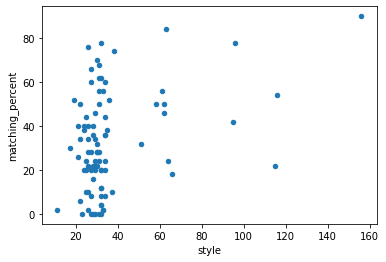

In [186]:
final_style.plot.scatter(x='style', y='matching_percent')

In [182]:
df.sample(10)

,index,name,style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty,state,country,retired
110,110,Get Up Offa That Brown,Ale Brown,Golden Road Brewing,5.5,3.72,15,25,6,70,8,38,68,11,0,8,42,7,155,CA,US,f
1396,1396,Bourbon County Brand Wheatwine,Wheat Beer Wheatwine,Goose Island Beer Co.,15.3,4.27,45,85,8,68,110,12,166,31,1,60,8,31,210,IL,US,f
1604,1604,La Trappe Isid'or,Ale Strong Pale,Bierbrouwerij De Koningshoeven B.V.,7.5,3.99,20,40,14,47,19,25,117,33,0,64,45,29,69,NaN,NL,f
397,397,Mexican Chocolate Stout,Herb and Spice Beer,Copper Kettle Brewing Company,7.0,3.94,5,40,5,103,25,24,66,8,0,7,10,152,77,CO,US,f
1463,1463,Rosie Parks Oyster Stout,Stout,Fordham Brewing Company,5.0,3.57,20,40,5,26,2,8,14,4,9,2,5,0,24,DE,US,f
661,661,Defenestration,Brett,Russian River Brewing Company,6.5,3.91,0,0,34,33,12,44,38,44,2,51,76,32,23,CA,US,f
3115,3115,Saranac Black Forest Black Beer,Lager Schwarzbier,Matt Brewing Company / Saranac Brewery,5.5,3.75,20,30,19,43,3,31,57,10,0,15,34,3,73,NY,US,f
261,261,Gorch Fock,Lager Helles,3 Floyds Brewing Co.,5.0,3.71,18,25,28,41,10,43,51,27,2,26,63,9,79,IN,US,f
50,50,Kentucky Bourbon Barrel Coffee Stout,Stout,Alltech's Lexington Brewing and Distilling Co.,8.0,3.76,20,40,13,70,50,105,53,7,0,8,13,20,176,KY,US,f
2499,2499,Femme Fatale Blanc,Brett,Evil Twin Brewing,6.0,4.05,0,0,28,40,10,55,77,112,1,123,79,16,28,NY,US,f


In [189]:
final_style.sort_values('matching_percent', ascending=False).tail(20)

,index,style,matching_percent
36,Ale Cream,32,12.0
76,Porter Imperial,25,10.0
70,Lager Dark,26,10.0
14,Ale Red Imperial,37,10.0
29,Beer,32,8.0
64,Fruit and Field Beer,27,8.0
23,Ale Strong Dark,34,8.0
83,Eisbock,22,6.0
30,Doppelbock,32,4.0
27,Wheat Dunkelweizen,32,4.0


In [190]:
final_style.sort_values('matching_percent', ascending=False).head(20)

,index,style,matching_percent
0,IPA,156,90.0
7,Rye Beer,63,84.0
3,Stout,96,78.0
32,Sour Berliner Weisse,32,78.0
67,Low Alcohol Beer,26,76.0
13,Brett,38,74.0
44,NEIPA,30,70.0
39,Sour Gose,31,68.0
60,Gueuze,27,66.0
42,Smoked,31,62.0


In [191]:
final_style.head(20)

,index,style,matching_percent
0,IPA,156,90.0
1,Ale Pale,116,54.0
2,Lager,115,22.0
3,Stout,96,78.0
4,Ale Brown,95,42.0
5,Pilsner,66,18.0
6,Barleywine,64,24.0
7,Rye Beer,63,84.0
8,Ale Blonde,62,46.0
9,Ale Strong,62,50.0


In [192]:
# specific columns to implement
features_to_implement = ['milk', 'old', 'dark', 'wild', 'pale', 'red', 'imperial']

In [236]:
style_xls = pd.read_excel('../assets/style_convert.xlsx')
style_xls.columns = style_xls.iloc[0, :]
style_xls = style_xls.iloc[1:, 1:]
style_xls.set_index('Converted', inplace=True)

# creation d'un dict pour replace de la correspondance
style_dict = style_xls.to_dict()
style_dict = style_dict['Simplified']
style_dict

/Users/alix/.pyenv/versions/3.8.6/envs/zytholic_project/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Altbier': 'Altbier',
 'Adjunct Lager - American': 'Lager',
 'Ale Red - American': 'Ale Red',
 'Lager Red- American': 'Lager',
 'Barleywine - American': 'Barleywine',
 'Ale Black - American': 'Ale Dark',
 'Ale Blonde - American': 'Ale',
 'Brett - American': 'Brett',
 'Ale Brown - American': 'Ale Dark',
 'IPA Brut- American': 'IPA',
 'Ale Cream - American': 'Ale',
 'Ale Dark Wheat - American': 'Ale Dark',
 'IPA imperial - American': 'IPA',
 'Pilsner Imperial - American': 'Pilsner',
 'Porter Imperial - American': 'Porter',
 'Ale Imperial Red - American': 'Ale Red',
 'Stout Imperial - American': 'Stout',
 'IPA - American': 'IPA',
 'Lager - American': 'Lager',
 'Lager Light - American': 'Lager',
 'Malt Liquor - American': 'Lager',
 'Ale Pale - American': 'Ale Pale',
 'Ale Pale Wheat - American': 'Wheat',
 'Porter - American': 'Porter',
 'Stout - American': 'Stout',
 'Ale Strong - American': 'Ale Strong',
 'Ale Wheatwine Ale - American': 'Wheat',
 'Ale Wild - American': 'Ale',
 'Porter Bal

In [237]:
styles_test = working_df[['style']].drop_duplicates()

In [238]:
styles_test['new'] = styles_test.replace(style_dict)

In [241]:
for feat in features_to_implement:
    styles_test[feat] = [1 if feat in elm.lower() else 0 for elm in styles_test['style']]

In [245]:
# Possibility to use this for joins
styles_test

,style,new,milk,old,dark,wild,pale,red,imperial
0,Altbier,Altbier,0,0,0,0,0,0,0
45,Barleywine - American,Barleywine,0,0,0,0,0,0,0
87,Barleywine - English,Barleywine,0,0,0,0,0,0,0
123,Bitter Strong - English,Bitter,0,0,0,0,0,0,0
152,Bitter - English,Bitter,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4197,Wheat Beer Kristallweizen,Wheat,0,0,0,0,0,0,0
4239,Wheat Beer Wheatwine,Wheat,0,0,0,0,0,0,0
4280,Wheat Beer Witbier,Wheat,0,0,0,0,0,0,0
4315,Ale Wild,Ale,0,0,0,1,0,0,0
